# Softmax Classifier with Tensorflow

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Requirements" data-toc-modified-id="Requirements-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Requirements</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Visualization</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Tensorflow-Placeholder" data-toc-modified-id="Tensorflow-Placeholder-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Tensorflow Placeholder</a></span></li></ul></li><li><span><a href="#Define-a-linear-classifier-using-Softmax" data-toc-modified-id="Define-a-linear-classifier-using-Softmax-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define a linear classifier using Softmax</a></span><ul class="toc-item"><li><span><a href="#Class-Scores,-Softmax,-Loss-functions" data-toc-modified-id="Class-Scores,-Softmax,-Loss-functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Class Scores, Softmax, Loss functions</a></span></li><li><span><a href="#Gradient-descent-optimizer" data-toc-modified-id="Gradient-descent-optimizer-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Gradient descent optimizer</a></span></li><li><span><a href="#Stochastical-gradient-descent" data-toc-modified-id="Stochastical-gradient-descent-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Stochastical gradient descent</a></span></li><li><span><a href="#Evaluate-model" data-toc-modified-id="Evaluate-model-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Evaluate model</a></span></li><li><span><a href="#Visualizing-the-weights/theta" data-toc-modified-id="Visualizing-the-weights/theta-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Visualizing the weights/theta</a></span></li></ul></li></ul></div>

## Requirements

### Imports

In [1]:
# All necessary imports at the beginning
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

from sklearn.datasets import fetch_mldata       
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 1.11.0


### Data

The MNIST dataset is a classic Machine Learning dataset you can get it and more information about it from the website of [Yann Lecun](http://yann.lecun.com/exdb/mnist/). MNIST contains handwrittin digits and is split into a tranings set of 60000 examples and a test set of 10000 examples. You can use the module ```sklearn``` to load the MNIST dataset in a convenient way. 
easy load, mldata.org, orginal mnist, mnist link and description

In [2]:
mnist = fetch_mldata('MNIST original') #load MNIST
X, y = mnist["data"], mnist["target"] #separate images and labels

# shape of MNIST data
print('digits', X.shape)
print('labels',y.shape)

digits (70000, 784)
labels (70000,)


/home/steven/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/steven/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


### Visualization

To get a visualization of MNIST we will plot our dataset. The function ```plot_mnist_digits(data, examples_each_row)``` plots as many examples of each class as defined by examples_each_row.Each column represents an image class. In the case of MNIST this means each row shows the same number class.

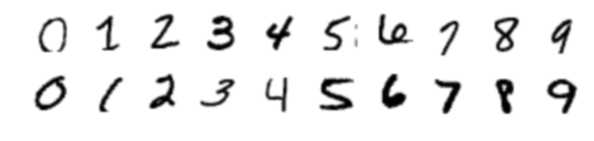

In [3]:
def plot_mnist_digits(data, examples_each_row):
    plt.figure(figsize=(10, examples_each_row))
    num_classes = 10
    X, y = data
    
    for c in range(num_classes):
        # Select samples_per_class random keys of the labels == current class
        keys = np.random.choice(np.where(y == c)[0], examples_each_row)
        images = X[keys]
        for i in range(examples_each_row):
            f = plt.subplot(examples_each_row, num_classes,
                            i * num_classes + c + 1)
            f.axis('off')
            plt.imshow(
                images[i].reshape(28, 28),
                cmap='binary',
                interpolation='bicubic')


plot_mnist_digits([X, y], examples_each_row=2)
plt.show()

### Data preparation

After exploring MNIST let us prepare the date for our linear classifier. First we need to separate traning and test data. Further we will shuffle the traning data to get a random distribution.  

In [4]:
# split data into training and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# shuffle training data
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

print('train data shape', X_train.shape)
print('test data shape', X_test.shape)

train data shape (60000, 784)
test data shape (10000, 784)


In [5]:
# Support function to convert label vector into a one hot encoding matrix
def onehot_encode_label(label):
    onehot_encoder = OneHotEncoder(sparse=False)
    label = label.reshape(len(label), 1)
    onehot_encoded_label = onehot_encoder.fit_transform(label)
    return onehot_encoded_label

We also need to transform our labels into onehot encoded vectors.

In [6]:
y_train, y_test = onehot_encode_label(y_train), onehot_encode_label(y_test)
print('train label shape', y_train.shape)
print('test label shape', y_test.shape)

train label shape (60000, 10)
test label shape (10000, 10)


/home/steven/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/steven/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'"

### Tensorflow Placeholder

So far we have used numpy arrays to manage our data, but in order to build a model in tensorflow we need another structure, the placeholder. A placeholder is simply a variable that we will assign data to at a later date. It allows us to create our operations and build our computation graph, without needing the data. In TensorFlow terminology, we then feed data into the graph through these placeholders.

In [7]:
# input X: 28x28 grayscale images, the first dimension (None) will index the images in the mini-batch
X_ = tf.placeholder(tf.float32, [None, 784])
# correct answers will go here
Y_ = tf.placeholder(tf.float32, [None, 10])

We created a placeholder for the input, output - a place in memory where we will store value later on.

## Define a linear classifier using Softmax

We will train a model to classify the MNIST dataset with the following equation:

$$ L = \frac{1}{M} \sum_{i=1}^{M} -log\; \left ( \frac{e^{h(x_j,\Theta)}}{\sum_{k=1}^{K}e^{h(x_k,\Theta)}} \right)_i , \: with \;\; h(X,\Theta) = X * \Theta $$

Using the universal equation for a loss function we can see the separate parts of that hugh equation.  

$$ L = \frac{1}{N} \sum_i L_i(h(x_i,\Theta),y_i)$$

We will implement each part on its own and put them together. That way it is much easier to understand whats going on.

### Class Scores, Softmax, Loss functions

Let us start with the score function or hypothesis:

$$h(X,\Theta) = X * \Theta$$

It is possible to calculate all score values with one matrix multiplication ([dot product](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.dot.html)) so we can use the whole traning data $X$ instead of one digit $x_i$.

In [8]:
def class_scores(X, theta):
    '''
    We get X - the input data as a placeholder and theta (our learnable parameter) as variable
    and return a new tensor with the dot product as operation.
    '''
    return tf.matmul(X, theta)

We assume the score values are unnormalized log probabilities and we use the softmax function to calculate probabilities.
$$ P(Y=j\mid X=x_i) = \frac{e^{s_j}}{\sum_{k=1}^{K}e^{s_k}} $$

In [9]:
def softmax(class_scores):
    '''
    Gets the class scores as tensor and calculates the softmax tensor of it.
    '''
    return tf.nn.softmax(class_scores)

Now we will calculate loss $L$ using the defined functions. 

$$ 
L = \frac{1}{M} \sum_i L_i(h(x_i,\Theta),y_i) + \lambda R(\Theta) \; \text{with} \;  L_i = -log\;P(Y=j\mid X=x_i) 
$$

Besides the loss L we will have to calculate the gradient for our loss function $L$. To get the gradient, we normally would need to calculate the gradient by hand. **But because we are using a framework, there is no need for this. The framework will do it for you. You only have to specify the forward path**

In [10]:
def loss(X, theta, class_labels):
    Z = class_scores(X, theta)
    Y = softmax(Z)
    # *10 because  "mean" included an unwanted division by 10
    cross_entropy = -tf.reduce_mean(class_labels * tf.log(Y)) * 10
    gradient = tf.gradients(cross_entropy, theta)
    return cross_entropy, gradient

In [11]:
theta = tf.Variable(tf.zeros([784, 10]))
scores = class_scores(X_, theta)
soft = softmax(scores)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    test = sess.run(soft, feed_dict={X_:X_train})
    print(test.shape)

(60000, 10)


### Gradient descent optimizer
Gradient descent is a way to minimize our loss functions - it iteratively moves toward a set of parameter values that minimize our loss function. This is achieved , in the simplest case, using calculus by taking steps in the negative direction of the gradient.

In [12]:
def gradient_descent(training_data, training_label, theta, iterations=10, learning_rate=1e-5):
    losses = []

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in tqdm(range(iterations)):
        l, grad = loss(X_, Y_, theta)
        loss_value, gradient = loss(X_, theta, Y_)
        
        # calculating loss value
        l = sess.run(loss_value, feed_dict={X_: training_data, Y_: training_label})
        losses.append(l)
        
        # trainings step
        grad = sess.run(gradient, feed_dict={X_: training_data, Y_: training_label})[0]
        theta = theta - learning_rate*grad
    return theta, losses, sess


# Start optimization with traning data, theta and optional hyperparameters
theta = tf.Variable(tf.zeros([784, 10]))
opt_model, loss_history, sess = gradient_descent(X_train, y_train, theta)
loss_history

100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


[2.3025851,
 1.7197862,
 1.3874726,
 1.1929573,
 1.086797,
 0.994465,
 0.96948636,
 0.8473393,
 0.82336354,
 0.7672825]

### Stochastical gradient descent
In stoachstical gradient descent the gradient is computed with a few training examples or a minibatch as opposed to a single example. 

The reason for this is: 
first this reduces the variance in the parameter update and can lead to more stable convergence, 
second this allows the computation to take advantage of highly optimized matrix operations that should be used in a well vectorized computation of the cost and gradient. 

A typical minibatch size is 256, although the optimal size of the minibatch can vary for different applications and architectures.

In [13]:
def sgd(training_data, training_label, theta, iterations=100, learning_rate=1e-5, batch_size=256):
    losses = []
    
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for i in tqdm(range(iterations)):
        # create a minibatch
        shuffle_index = np.random.permutation(training_data.shape[0])
        data, label = training_data[shuffle_index], training_label[shuffle_index]
        data, label = data[:batch_size], label[:batch_size]
        
        loss_value, gradient = loss(X_, theta, Y_)
        # calculate loss value
        l = sess.run(loss_value, feed_dict={X_: data, Y_: label})            
        losses.append(l)
        # trainings step
        grad = sess.run(gradient, feed_dict={X_: data, Y_: label})[0]
        theta = theta - learning_rate*grad
    return theta, losses, sess

theta = tf.Variable(tf.zeros([784, 10]))
# Start optimization with traning data, theta and optional hyperparameters
opt_model, loss_history, sess = sgd(X_train, y_train, theta)

100%|██████████| 100/100 [00:17<00:00,  3.73it/s]


### Evaluate model
Let us look at the optimization results. Final loss tells us how far we could reduce costs during traning process. Further we can use the first loss value as a sanity check and validate our implementation of the loss function works as intended. Recall loss value after first iteration should be $ log\:c$ with $c$ being number of classes. To visulize the whole tranings process we can plot losss values from each iteration as a loss curve. 

last iteration loss: 0.50813836
first iteration loss: 2.3025851


Text(0.5, 0, 'iterations')

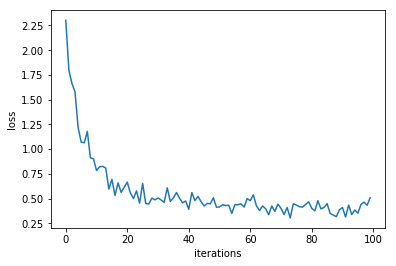

In [14]:
# check loss after last iteration
print('last iteration loss:',loss_history[-1])
# Sanity check: first loss should be ln(10)
print('first iteration loss:',loss_history[0])
# Plot a loss curve
plt.plot(loss_history)
plt.ylabel('loss')
plt.xlabel('iterations')

Evaluation above gave us some inside about the optimization process but did not quantified our final model. One possibility is to calculate model accuracy.

In [15]:
def modelAccuracy(X, y, theta, sess):
    # calculate probabilities for each digit
    probabilities = softmax(class_scores(X_, theta))
    # accuracy of the trained model, between 0 (worst) and 1 (best)
    correct_prediction = tf.equal(tf.argmax(probabilities, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    accuracy = sess.run(correct_prediction, feed_dict={X_: X, Y_: y})
    return len(np.where(accuracy == True)[0]) / len(accuracy)


print('Test accuracy: ', modelAccuracy(X_test, y_test, opt_model, sess))

Test accuracy:  0.8967


### Visualizing the weights/theta
One of the benefits of a simple model like softmax is that we can visualize the weights $theta$ for each of the classes, and see what it prefers. Here we look at one random weight of each class.

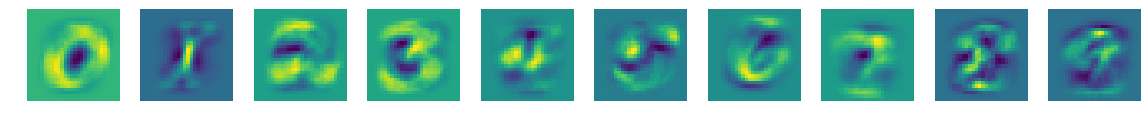

In [16]:
plt.figure(figsize=(20, 20))
num_classes = 10

opt_theta = sess.run(opt_model)
for c in range(num_classes):
    f = plt.subplot(10, num_classes, 1 * num_classes + c + 1)
    f.axis('off')
    plt.imshow(np.reshape(opt_theta[:,c],[28,28]))
plt.show()